In [11]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt # type: ignore

In [12]:
np.__version__

'1.24.1'

In [13]:
torch.__version__

'2.1.2+cu118'

In [14]:
torch.cuda.is_available()

True

In [15]:
help(torch.randn)

Help on built-in function randn in module torch:

randn(...)
    randn(*size, *, generator=None, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False, pin_memory=False) -> Tensor
    
    
    Returns a tensor filled with random numbers from a normal distribution
    with mean `0` and variance `1` (also called the standard normal
    distribution).
    
    .. math::
        \text{out}_{i} \sim \mathcal{N}(0, 1)
    
    The shape of the tensor is defined by the variable argument :attr:`size`.
    
    Args:
        size (int...): a sequence of integers defining the shape of the output tensor.
            Can be a variable number of arguments or a collection like a list or tuple.
    
    Keyword args:
        generator (:class:`torch.Generator`, optional): a pseudorandom number generator for sampling
        out (Tensor, optional): the output tensor.
        dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
            Default: i

In [16]:
help(np.random.normal)

Help on built-in function normal:

normal(...) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    .. note::
        New code should use the `~numpy.random.Generator.normal`
        method of a `~numpy.random.Generator` instance instead;
        please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    loc : float or array_like of floats
     

In [17]:
# let's prepare data
n_samples = 500

In [18]:
x = torch.rand((n_samples, 1), dtype=torch.float) * 10

x.shape

torch.Size([500, 1])

In [19]:
# let's define some noise
noise = np.random.normal(loc=1.2, scale=2.1, size=(n_samples, 1))
noise.shape

(500, 1)

In [20]:
y = 5.5 - (2.6*x) + noise
y = y.float()
y.shape

torch.Size([500, 1])

In [21]:
x.dtype, y.dtype

(torch.float32, torch.float32)

In [22]:
def plot_scatter(x, y, y_pred=None, title='Scatter Plot', xlabel='x', ylabel='y', 
                    figsize=(6, 4), marker_color='blue', marker_edgecolor='black', marker_size=100, alpha=0.75):
    
    plt.figure(figsize=figsize)  # Set figure size
    
    # Plot actual values
    plt.scatter(x, y, color=marker_color, edgecolor=marker_edgecolor, s=marker_size, alpha=alpha, label='Actual')
    
    # Plot predicted values if y_pred is provided
    if y_pred is not None:
        plt.scatter(x, y_pred, color='red', edgecolor='black', s=marker_size, alpha=0.75, label='Predicted')

    # Add labels and title
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend if predictions are plotted
    if y_pred is not None:
        plt.legend()

    # Display the plot
    plt.show()

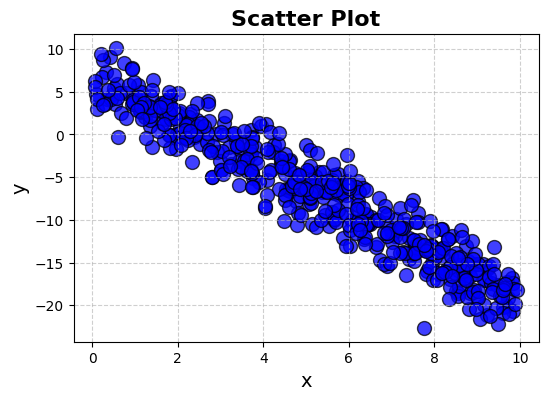

In [23]:
plot_scatter(x, y)

In [24]:
# let's perform train-test split
train_split = int(0.75 * x.shape[0])

X_train, y_train = x[:train_split, :], y[:train_split, :]
X_test, y_test = x[train_split:, :], y[train_split:, :]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([375, 1]),
 torch.Size([375, 1]),
 torch.Size([125, 1]),
 torch.Size([125, 1]))

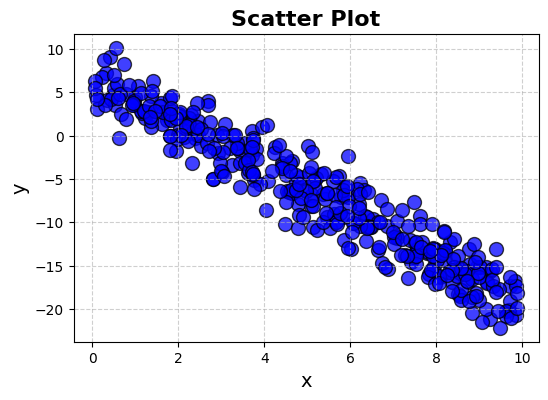

In [25]:
plot_scatter(X_train, y_train)

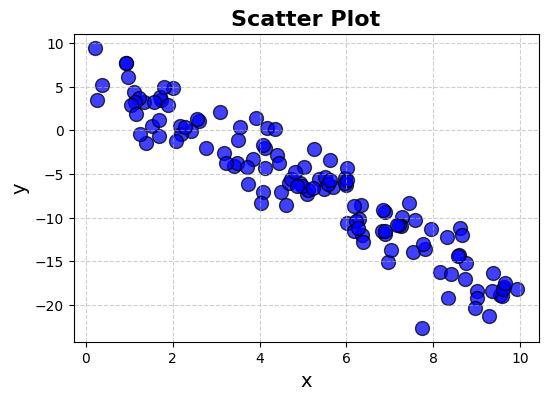

In [26]:
plot_scatter(X_test, y_test)

##### Build the model

In [27]:

class LinearRegressionModel(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.weights = nn.Parameter(torch.randn(1, 
                                                requires_grad=True, 
                                                dtype=torch.float)
                                    )
        
        self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float)
                                    )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [28]:
linear_model = LinearRegressionModel()
list(linear_model.parameters())

[Parameter containing:
 tensor([0.3690], requires_grad=True),
 Parameter containing:
 tensor([1.8634], requires_grad=True)]

In [29]:
linear_model.state_dict()

OrderedDict([('weights', tensor([0.3690])), ('bias', tensor([1.8634]))])

* **Training Phase:**

    Forward pass → Compute loss → Zero gradients → Backward pass (compute gradients) → Update parameters (using optimizer).

* **Testing Phase:**

    Model evaluation (no gradient calculation) → Forward pass → Compute test loss.

* **Progress Monitoring:**

    Every 10 epochs, print and log the training and testing losses.

In [30]:
# define the loss fn
loss_fn = nn.MSELoss()

# setup an optimizer
optimizer = torch.optim.SGD(params=linear_model.parameters(),
                            lr=0.01)

In [31]:
# Set the number of epochs (how many times the model will pass over the training data)
epochs = 500

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    linear_model.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = linear_model(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    linear_model.eval()

    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = linear_model(X_test)

        # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}\n")
        
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())

Epoch: 0 | MSE Train Loss: 184.1322479248047 | MSE Test Loss: 24.285951614379883

Epoch: 10 | MSE Train Loss: 9.979534149169922 | MSE Test Loss: 11.506421089172363

Epoch: 20 | MSE Train Loss: 9.514260292053223 | MSE Test Loss: 11.050002098083496

Epoch: 30 | MSE Train Loss: 9.088689804077148 | MSE Test Loss: 10.631437301635742

Epoch: 40 | MSE Train Loss: 8.699438095092773 | MSE Test Loss: 10.247557640075684

Epoch: 50 | MSE Train Loss: 8.343401908874512 | MSE Test Loss: 9.895447731018066

Epoch: 60 | MSE Train Loss: 8.017749786376953 | MSE Test Loss: 9.57243537902832

Epoch: 70 | MSE Train Loss: 7.719888210296631 | MSE Test Loss: 9.27608585357666

Epoch: 80 | MSE Train Loss: 7.447444438934326 | MSE Test Loss: 9.004159927368164

Epoch: 90 | MSE Train Loss: 7.198251247406006 | MSE Test Loss: 8.754611015319824

Epoch: 100 | MSE Train Loss: 6.970322132110596 | MSE Test Loss: 8.525565147399902

Epoch: 110 | MSE Train Loss: 6.761845588684082 | MSE Test Loss: 8.315308570861816

Epoch: 120 |

In [32]:
linear_model.state_dict()

OrderedDict([('weights', tensor([-2.5169])), ('bias', tensor([6.0997]))])

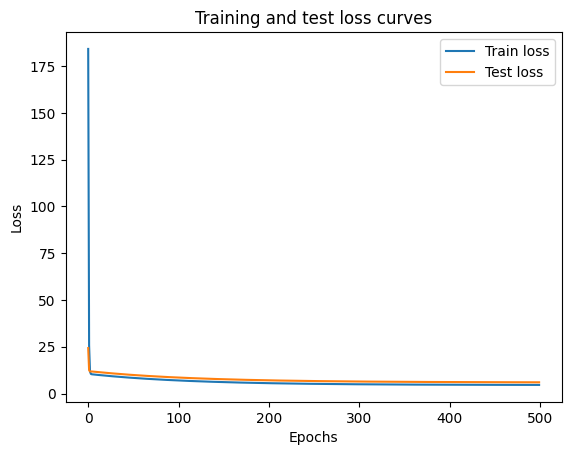

In [33]:
# Plot the loss curves
plt.plot(range(epochs), train_loss_values, label="Train loss")
plt.plot(range(epochs), test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [34]:
# make prediction with model

with torch.inference_mode():
    y_pred = linear_model(X_test)

y_pred.shape

torch.Size([125, 1])

In [35]:
error = (y_pred - y_test)
squared_error = torch.sum(error**2, dim=0)
mse = squared_error / y_test.shape[0]
mse

tensor([5.9986])

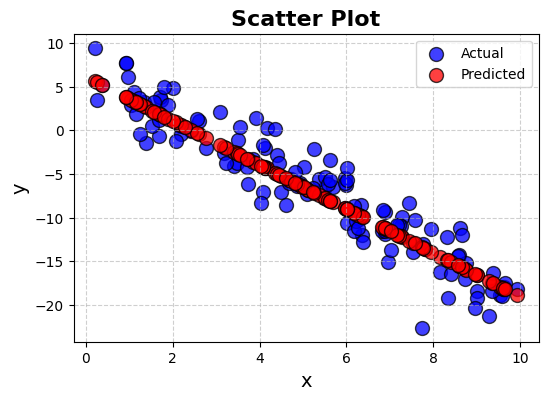

In [36]:
plot_scatter(X_test, y_test, y_pred=y_pred)

In [37]:
((y_pred - y_test) ** 2).mean()

tensor(5.9986)

* PyTorch's autograd to differentiate the loss without relying on `nn.MSELoss()` and `optimizer.step()`

In [38]:
linear_model1 = LinearRegressionModel()

In [39]:

def loss_fn(y_pred: torch.Tensor, y_true: torch.Tensor):
    return ((y_pred - y_true) ** 2).mean()

In [40]:
# set the learning rate
lr = 0.01
epochs = 500

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []



for epoch in range(epochs):
    
    # put the model in training mode
    linear_model1.train()
    
    # forward pass: compute the model prediction
    y_pred = linear_model1.forward(X_train)
    
    # compute the loss: MSE
    loss = loss_fn(y_pred=y_pred, y_true=y_train)
    
    # gradients calculation
    # use autograd to compute gradients of the loss with respect to weights and bias
    gradients = torch.autograd.grad(loss, [linear_model1.weights, linear_model1.bias], create_graph=True)
    
    # optimization step
    # Update the model's parameters manually using gradient descent
    with torch.no_grad():
        linear_model1.weights.data -= (lr * gradients[0])
        linear_model1.bias.data -= (lr * gradients[1])
    
    # put the model in evaluation mode
    linear_model1.eval()
    
    with torch.inference_mode():
        y_pred_test = linear_model1.forward(X_test)
        
        test_loss = loss_fn(y_pred=y_pred_test, y_true=y_test)
        
        # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}\n")
        
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())

Epoch: 0 | MSE Train Loss: 334.92095947265625 | MSE Test Loss: 38.443424224853516

Epoch: 10 | MSE Train Loss: 12.424406051635742 | MSE Test Loss: 13.889537811279297

Epoch: 20 | MSE Train Loss: 11.750493049621582 | MSE Test Loss: 13.234806060791016

Epoch: 30 | MSE Train Loss: 11.1340913772583 | MSE Test Loss: 12.634625434875488

Epoch: 40 | MSE Train Loss: 10.570291519165039 | MSE Test Loss: 12.084420204162598

Epoch: 50 | MSE Train Loss: 10.054604530334473 | MSE Test Loss: 11.579972267150879

Epoch: 60 | MSE Train Loss: 9.582923889160156 | MSE Test Loss: 11.11743450164795

Epoch: 70 | MSE Train Loss: 9.151493072509766 | MSE Test Loss: 10.693278312683105

Epoch: 80 | MSE Train Loss: 8.756881713867188 | MSE Test Loss: 10.304277420043945

Epoch: 90 | MSE Train Loss: 8.395943641662598 | MSE Test Loss: 9.947474479675293

Epoch: 100 | MSE Train Loss: 8.06580924987793 | MSE Test Loss: 9.62016773223877

Epoch: 110 | MSE Train Loss: 7.763846397399902 | MSE Test Loss: 9.319879531860352

Epoch

In [41]:
linear_model1.state_dict()

OrderedDict([('weights', tensor([-2.5000])), ('bias', tensor([5.9877]))])

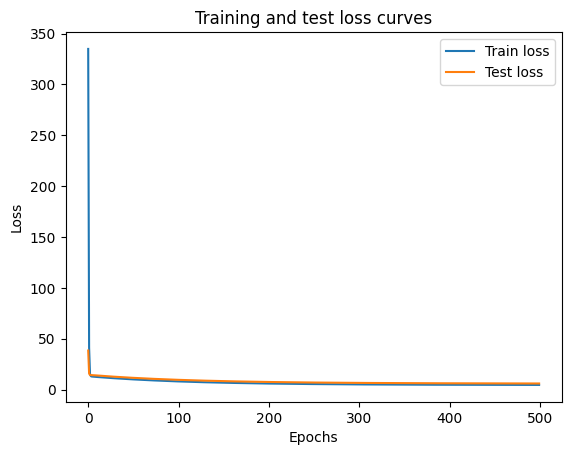

In [42]:
# Plot the loss curves
plt.plot(range(epochs), train_loss_values, label="Train loss")
plt.plot(range(epochs), test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

#### **Important Notes:**

* **How does `torch.autograd.grad()` work?**

    * When you pass `loss` (a scalar) and the parameters `(like weights and bias)` to `torch.autograd.grad()`, PyTorch uses the computation graph that was built during the forward pass to compute the partial derivatives of the loss with respect to the parameters. It applies the chain rule to figure out how changes in the parameters will affect the loss.

* Here’s a simple breakdown:

* **Forward pass:** 
    * During the forward pass, PyTorch tracks how the input data flows through the model, and how the model parameters are used in computations.
Computation graph: PyTorch builds a computational graph where nodes represent operations and edges represent data flow. The loss depends on the model parameters, so they are connected in the graph.

* **Backward pass:**  
    * When you compute the gradients (either using loss.backward() or `torch.autograd.grad()`), PyTorch traverses this graph in reverse and calculates the gradients of the loss with respect to each parameter using the chain rule.

##### **Summary:**

* Even though you are passing a scalar loss value to `torch.autograd.grad()`, PyTorch can compute the gradients because it keeps track of how that scalar loss was computed through the computation graph.

* It applies the chain rule to compute the gradients with respect to each parameter in the graph.
The scalar loss is the result of multiple operations that involve the parameters (weights and bias), and the gradients reflect how the loss changes when you slightly change those parameters.

* **Why Pass the `Loss` to `torch.autograd.grad()`?**

    * You might wonder why we need to pass the `loss` explicitly to `torch.autograd.grad()` if everything is already in the computation graph. Here’s the key reason:

    **Targeted Gradient Calculation:**
    * With `torch.autograd.grad()`, you're asking PyTorch to compute the gradient of a specific scalar value (in this case, the loss) with respect to specific tensors.
    The loss is the end result of a series of operations that depend on many variables (weights, bias, etc.). By passing the `loss` to `torch.autograd.grad()`, you're explicitly telling PyTorch, "I want to compute how this scalar (loss) changes with respect to these particular tensors."

    While the computation graph contains all the operations, `torch.autograd.grad()` lets you define which gradients you want and for which tensors.


    **In contrast:**
    * `loss.backward()` does not give you control over which tensors to compute gradients for. It computes gradients for all parameters in the computation graph that have `requires_grad=True`.



    **When Would You Use torch.autograd.grad()?**
    * Here are some specific cases where `torch.autograd.grad()` is useful:

    * **Higher-Order Gradients:** When you need to compute gradients of gradients (for example, in some advanced optimization techniques), you would use torch.autograd.grad() with create_graph=True.

                * #Compute first-order gradient
                `first_gradients = torch.autograd.grad(loss, [w], create_graph=True)`

                * #Compute second-order gradient (gradient of the first gradient)
                `second_gradients = torch.autograd.grad(first_gradients[0], [w])`

    * **Selective Gradients:** 
        If you have a model with many parameters, but you only want to compute the gradient with respect to a few specific tensors, you can use `torch.autograd.grad()` to avoid unnecessary computations.

            `gradients = torch.autograd.grad(loss, [specific_param])`
    
    * **Gradient Manipulation:** 
        Sometimes, you might want to manually manipulate the gradients before applying them to update parameters. Using `torch.autograd.grad()` gives you access to the gradients as tensors, so you can modify them as needed.
    
    * **Custom Updates:** 
        In some cases, you might not want to update all model parameters or you may want to apply custom update rules. In such cases, `torch.autograd.grad()` allows you to compute gradients without storing them in `.grad`, enabling you to do your own updates.


In [43]:
linear_model.state_dict()

OrderedDict([('weights', tensor([-2.5169])), ('bias', tensor([6.0997]))])

In [44]:
linear_model1.state_dict()

OrderedDict([('weights', tensor([-2.5000])), ('bias', tensor([5.9877]))])

In [45]:
# saving a model in PyTorch
from pathlib import Path

In [46]:
# model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "01_pytorch_workflow_model0.pth"

# create model save path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

WindowsPath('models/01_pytorch_workflow_model0.pth')

In [47]:
# save the model state_dict()
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(linear_model.state_dict(), 
            f=MODEL_SAVE_PATH)

saving model to: models\01_pytorch_workflow_model0.pth


In [48]:
# Model class must be defined somewhere
loaded_model0 = torch.load(f=MODEL_SAVE_PATH)
loaded_model0

OrderedDict([('weights', tensor([-2.5169])), ('bias', tensor([6.0997]))])

In [49]:
loaded_model0_1 = LinearRegressionModel()
loaded_model0_1.state_dict()

OrderedDict([('weights', tensor([0.4493])), ('bias', tensor([-0.4455]))])

In [50]:
loaded_model0_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [52]:
loaded_model0_1

LinearRegressionModel()

In [51]:
loaded_model0_1.state_dict()

OrderedDict([('weights', tensor([-2.5169])), ('bias', tensor([6.0997]))])

In [53]:
loaded_model0_1.eval()

with torch.inference_mode():
    loaded_model_pred = loaded_model0_1(X_test)


In [54]:
((loaded_model_pred - y_test) ** 2).mean()

tensor(5.9986)